In [1]:
using ReactiveMP, Rocket, GraphPPL
using KernelFunctions, LinearAlgebra, Random, Plots
using Distributions 

## 1) Create meta

In [2]:
mutable struct GPMeta{X,T,K}
    x::X
    θ::T
    kernel::K 
end
## Note that here I assume the GP is zero-mean, so we only need to define kernel
get_x(meta::GPMeta) = meta.x # this is a collection of inducing points x = [x_1, x_2, ..., x_m]
get_params(meta::GPMeta) = meta.θ  # θ stores magnitude scale θ[1] and length-scale θ[2] 
get_kernel(meta::GPMeta) = meta.kernel


get_kernel (generic function with 1 method)

## 2) Create GPPrior node

In [3]:
struct GPPrior end

@node GPPrior Stochastic [out]

### Rules for GPPrior node 

In [4]:
@rule GPPrior(:out, Marginalisation) (meta::GPMeta, ) = begin 
    x = get_x(meta) #get inducing points
    θ = get_params(meta) #get hyperparameters
    k = get_kernel(meta) # this is the kernel without any additional parameters from users
    kernel = θ[1] * with_lengthscale(k, θ[2]) #add parameters to the kernel

    K_xx = kernelmatrix(kernel, x) # compute the covariance matrix from x 
    
    return MvNormalMeanCovariance(zeros(length(x)),K_xx)
end

## 3) Create GPPrediction Node

In [5]:
struct GPPrediction end

@node GPPrediction Stochastic [out, in, f]

### Rules for GPPrediction node

In [6]:
@rule GPPrediction(:f, Marginalisation) (q_out::PointMass, q_in::PointMass, meta::GPMeta,) = begin
    input, output = mean(q_in), mean(q_out)
    k = get_kernel(meta)
    X = get_x(meta) # X from meta
    kernel = θ[1] * with_lengthscale(k, θ[2]) # kernel with user hyperparameters

    K_xx = kernelmatrix(kernel, X) + 1e-8*diageye(length(X))#covariance matrix from meta 
    if typeof(input) <: Vector
        K_x = kernelmatrix(kernel, input, X) #cross-covariance matrix k(x,X) between input x (vector) and X from meta 
    else
        K_x = kernelmatrix(kernel, [input], X) # in this case, input is scalar, so we convert it to vector
    end

    α  = K_x * inv(K_xx)
    α_inv = α'/norm(α)^2 
    σ² = kernelmatrix(kernel, [input]) - K_x * inv(K_xx) * K_x' # predictive variance  

    m = output * α_inv # the mean of the backward message toward in 
    A = α' * α
    Σ = inv(A + 1e-8*diageye(length(A[:,1]))) / σ²[] # the covariance matrix of the backward message toward "in" 

    return MvNormalMeanCovariance(vec(m), Σ)
end 

## Model

In [7]:
@model function gp_regress(input, X, kernel, θ, n)
    f ~ GPPrior() where {meta = GPMeta(X, θ, kernel)}
    y = datavar(Float64,n)

    for i=1:n
        y[i] ~ GPPrediction(input[i],f) where {meta = GPMeta(X, θ, kernel)}
    end

    return f, y
end

## Inference

In [8]:
function inference(input, output, X, kernel, θ)
    n = length(output)
    model, (f,y) = gp_regress(model_options(limit_stack_depth=100), input, X, kernel, θ, n)

    marginal_f = keep(Marginal)
    subscription = subscribe!(getmarginal(f), marginal_f)

    update!(y, output)
    unsubscribe!(subscription)
    return marginal_f
end

inference (generic function with 1 method)

## Generate data

In [16]:
Random.seed!(14)
x_input = range(0, 5, length=100); #input
f_true = 2*sin.(x_input) .+ cos.(2*x_input); # true process

pos = randperm(length(x_input))[20:5:100]; # position where we observe data
x_obser = x_input[pos]; # x-positions of observed point
y_obser = f_true[pos] #+ 0.5*randn(length(x_obser)); # noisy observation
#for meta information
X = collect(x_input)
θ = [1., 1.3]; # θ = [σ², length-scale]

In [17]:
f_estimate = inference(x_obser, y_obser, X, SEKernel(), θ);

In [18]:
meanfunc, covmatrix = mean_cov(f_estimate.values[]);
variance = diag(covmatrix); # take out the main diagonal of covariance matrix  

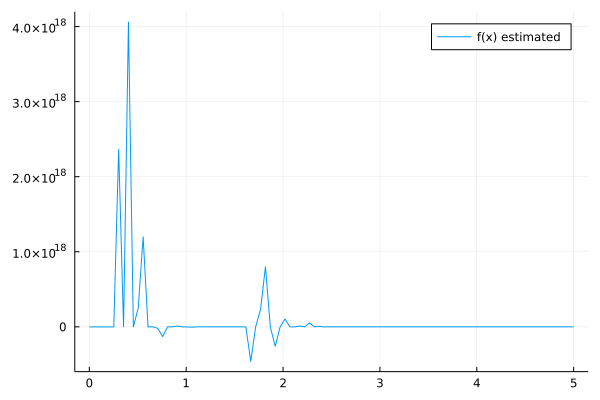

In [19]:
plot(X, meanfunc, label="f(x) estimated")

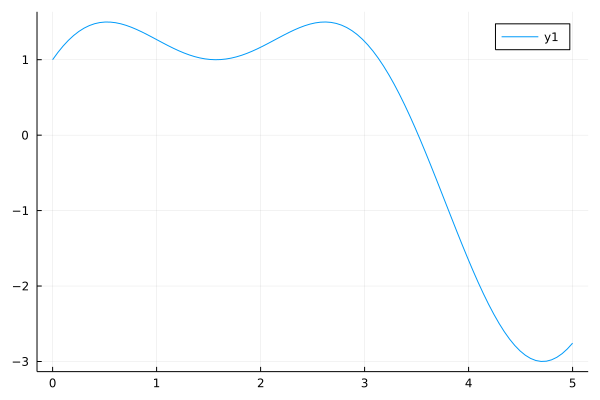

In [15]:
plot(x_input,f_true)